In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from time import perf_counter

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input

from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
!gdown 1r8BvjiakPswIqnlZRYfRE47SgwYXLekB

Downloading...
From: https://drive.google.com/uc?id=1r8BvjiakPswIqnlZRYfRE47SgwYXLekB
To: /content/Flower.zip
100% 236M/236M [00:04<00:00, 54.4MB/s]


In [ ]:
!unzip Flower

Archive:  Flower.zip
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/10140303196_b88d3d6cec.jpg  
  inflating: flowers/daisy/10172379554_b296050f82_n.jpg  
  inflating: flowers/daisy/10172567486_2748826a8b.jpg  
  inflating: flowers/daisy/10172636503_21bededa75_n.jpg  
  inflating: flowers/daisy/102841525_bd6628ae3c.jpg  
  inflating: flowers/daisy/10300722094_28fa978807_n.jpg  
  inflating: flowers/daisy/1031799732_e7f4008c03.jpg  
  inflating: flowers/daisy/10391248763_1d16681106_n.jpg  
  inflating: flowers/daisy/10437754174_22ec990b77_m.jpg  
  inflating: flowers/daisy/10437770546_8bb6f7bdd3_m.jpg  
  inflating: flowers/daisy/10437929963_bc13eebe0c.jpg  
  inflating: flowers/daisy/10466290366_cc72e33532.jpg  
  inflating: flowers/daisy/10466558316_a7198b87e2.jpg  
  inflating: flowers/daisy/10555749515_13a12a026e.jpg  
  inflating: flowers/daisy/10555815624_dc211569b0.jpg  
  inflating: flowers/daisy/10555826524_423eb8bf71_n.jpg  
  inflating: flo

In [ ]:
image_dir = Path('/content/flowers')
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

image_df = pd.concat([filepaths, labels], axis=1)

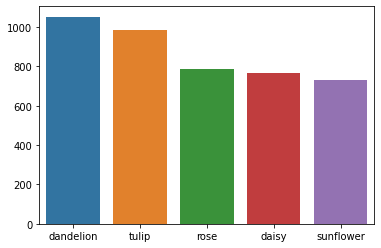

In [ ]:
sns.barplot(x=image_df.Label.value_counts().index, y=image_df.Label.value_counts().values)
plt.show()

In [ ]:
train_ds, test_ds = train_test_split(image_df, test_size=0.2, shuffle=True, random_state=1)

In [ ]:
train_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(train_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)
test_ds = ImageDataGenerator(rescale = 1./255).flow_from_dataframe(test_ds,
                                                                 x_col='Filepath',
                                                                 y_col='Label',
                                                                 target_size=(224, 224),
                                                                 color_mode='rgb',
                                                                 class_mode='categorical',
                                                                 batch_size=32)

Found 3453 validated image filenames belonging to 5 classes.
Found 864 validated image filenames belonging to 5 classes.


##Train my own model

In [ ]:
def my_model(summary=False):
  input = layers.Input(shape=(224,224,3))

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu')(input)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(64, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.Conv2D(128, (3,3), kernel_initializer='he_normal', activation='relu', padding='same')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(256, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.4)(x)

  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.Conv2D(512, (3,3), kernel_initializer='he_normal', activation='relu')(x)
  x = layers.MaxPooling2D((2,2))(x)
  x = layers.Dropout(0.5)(x)

  x = layers.Flatten()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dense(1024, kernel_initializer='he_normal', activation='relu')(x)
  x = layers.BatchNormalization()(x)
  x = layers.Dropout(0.5)(x)

  output = layers.Dense(5, activation='softmax')(x)

  model = Model(input, output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(model.summary())
    
  return model

In [ ]:
model_own = my_model(summary=True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 110, 110, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 110, 110, 64)      36928     
                                                             

In [ ]:
start_tra = perf_counter()
history = model_own.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 50s 319ms/step - loss: 2.6096 - accuracy: 0.2328 - val_loss: 11.7545 - val_accuracy: 0.1898
Epoch 2/20
108/108 [==============================] - 31s 290ms/step - loss: 2.0724 - accuracy: 0.2517 - val_loss: 1.8689 - val_accuracy: 0.2176
Epoch 3/20
108/108 [==============================] - 31s 285ms/step - loss: 1.8903 - accuracy: 0.2644 - val_loss: 1.5975 - val_accuracy: 0.2442
Epoch 4/20
108/108 [==============================] - 30s 281ms/step - loss: 1.8528 - accuracy: 0.2554 - val_loss: 3.5169 - val_accuracy: 0.1933
Epoch 5/20
108/108 [==============================] - 31s 283ms/step - loss: 1.7932 - accuracy: 0.2583 - val_loss: 1.7696 - val_accuracy: 0.2407
Epoch 6/20
108/108 [==============================] - 31s 282ms/step - loss: 1.5653 - accuracy: 0.3313 - val_loss: 1.4344 - val_accuracy: 0.3692
Epoch 7/20
108/108 [==============================] - 31s 283ms/step - loss: 1.4564 - accuracy: 0.3776 - val_loss: 1.6093 - val_a

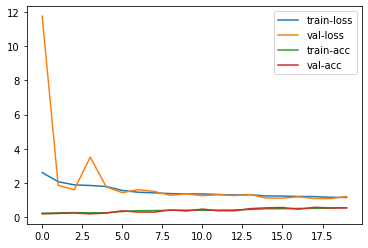

In [ ]:
plt.plot(history.history['loss'], label='train-loss')
plt.plot(history.history['val_loss'], label='val-loss')
plt.plot(history.history['accuracy'], label='train-acc')
plt.plot(history.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_own = model_own.evaluate(test_ds)[1]

27/27 [==============================] - 3s 120ms/step - loss: 1.2094 - accuracy: 0.5428


## TransferLearning Part 1 (Just change the last Dense layer--->to change the number of classes)

Notice that we can not use: vgg_model = VGG16(weights='imagenet',input_shape=(224,224,3), include_top=True, classes=10) because the model just accept imagenet weights when we don't change the number of its classes(1000); otherwise we should train the model on our dataset without imagenet weights and just use VGG's architecture (which is not useful beacuse of the time and low amount of data)

In [ ]:
# lest's first look at the complete VGG16 architecture
vgg_test = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)
vgg_test.summary()

553467096/553467096 [==============================] - 14s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
def VGG16_1(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)

  # for layer in vgg_model.layers[:]:
  #     layer.trainable = False
  # this part is just like:
  vgg_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = vgg_model.get_layer('fc2').output # this part is just like: output = vgg_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_1 = VGG16_1(summary=True)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_1 = vgg_1.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 31s 251ms/step - loss: 1.2102 - accuracy: 0.5416 - val_loss: 0.9020 - val_accuracy: 0.6829
Epoch 2/20
108/108 [==============================] - 24s 220ms/step - loss: 0.8663 - accuracy: 0.6800 - val_loss: 0.7872 - val_accuracy: 0.7095
Epoch 3/20
108/108 [==============================] - 23s 214ms/step - loss: 0.7772 - accuracy: 0.7191 - val_loss: 0.7293 - val_accuracy: 0.7512
Epoch 4/20
108/108 [==============================] - 23s 216ms/step - loss: 0.7623 - accuracy: 0.7205 - val_loss: 0.8643 - val_accuracy: 0.6713
Epoch 5/20
108/108 [==============================] - 23s 216ms/step - loss: 0.6867 - accuracy: 0.7617 - val_loss: 0.6776 - val_accuracy: 0.7662
Epoch 6/20
108/108 [==============================] - 23s 215ms/step - loss: 0.6965 - accuracy: 0.7469 - val_loss: 0.6802 - val_accuracy: 0.7546
Epoch 7/20
108/108 [==============================] - 23s 215ms/step - loss: 0.6414 - accuracy: 0.7721 - val_loss: 0.6761 - val_ac

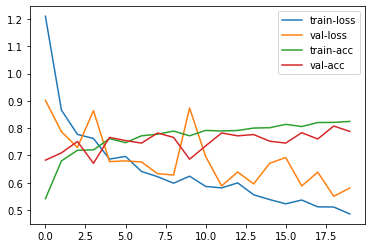

In [ ]:
plt.plot(history_1.history['loss'], label='train-loss')
plt.plot(history_1.history['val_loss'], label='val-loss')
plt.plot(history_1.history['accuracy'], label='train-acc')
plt.plot(history_1.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg1 = vgg_1.evaluate(test_ds)[1]

27/27 [==============================] - 5s 172ms/step - loss: 0.5808 - accuracy: 0.7882


## TransferLearning Part 2 (Change the last Layer and add some dense/dropout layers too)

In [ ]:
def VGG16_2(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)

  # for layer in vgg_model.layers[:]:
  #     layer.trainable = False
  # this part is just like:
  vgg_model.trainable = False

  # last fully connected layer before Dense(1000) in image net
  output = vgg_model.get_layer('fc2').output # this part is just like: output = vgg_model.layers[-2].output
  # output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_2 = VGG16_2(summary=True)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_2 = vgg_2.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 24s 219ms/step - loss: 1.6529 - accuracy: 0.4810 - val_loss: 0.9907 - val_accuracy: 0.6007
Epoch 2/20
108/108 [==============================] - 24s 217ms/step - loss: 0.9029 - accuracy: 0.6568 - val_loss: 0.8257 - val_accuracy: 0.6863
Epoch 3/20
108/108 [==============================] - 23s 215ms/step - loss: 0.7704 - accuracy: 0.7049 - val_loss: 0.9206 - val_accuracy: 0.6725
Epoch 4/20
108/108 [==============================] - 23s 216ms/step - loss: 0.7826 - accuracy: 0.6988 - val_loss: 0.7463 - val_accuracy: 0.7095
Epoch 5/20
108/108 [==============================] - 24s 218ms/step - loss: 0.6779 - accuracy: 0.7483 - val_loss: 0.7006 - val_accuracy: 0.7176
Epoch 6/20
108/108 [==============================] - 23s 216ms/step - loss: 0.6782 - accuracy: 0.7507 - val_loss: 0.7152 - val_accuracy: 0.7292
Epoch 7/20
108/108 [==============================] - 23s 216ms/step - loss: 0.6363 - accuracy: 0.7663 - val_loss: 0.6710 - val_ac

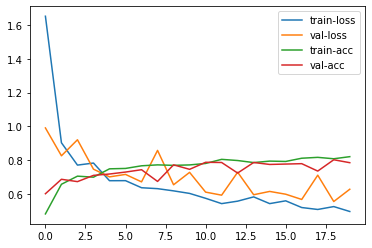

In [ ]:
plt.plot(history_2.history['loss'], label='train-loss')
plt.plot(history_2.history['val_loss'], label='val-loss')
plt.plot(history_2.history['accuracy'], label='train-acc')
plt.plot(history_2.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg2 = vgg_2.evaluate(test_ds)[1]

27/27 [==============================] - 5s 181ms/step - loss: 0.6273 - accuracy: 0.7847


## TransferLearning Part 3 (Open the last trainable layers and add some dense/dropout layers)

In [ ]:
def VGG16_3(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=True)

  # for layer in vgg_model.layers[:]:
  #     layer.trainable = False
  # this part is just like:
  vgg_model.trainable = False

  # let the layers after last block anf fully connected layers be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv1':
      set_trainable=True
    lyr.trainable = set_trainable

  # last fully connected layer before Dense(1000) in image net
  output = vgg_model.get_layer('fc2').output # this part is just like: output = vgg_model.layers[-2].output
  output = layers.Flatten(name='new_flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='first_new_fc')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='last_new_fc')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)
  vgg_model = Model(vgg_model.input, output)

  # vgg_model.get_layer('block5_conv3').trainable = True
  # vgg_model.get_layer('fc1').trainable = True
  # vgg_model.get_layer('fc2').trainable = True
  # vgg_model.get_layer('first_new_fc').trainable = True

  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_3 = VGG16_3(summary=True)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_3 = vgg_3.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 30s 269ms/step - loss: 2.3179 - accuracy: 0.2525 - val_loss: 1.7578 - val_accuracy: 0.2176
Epoch 2/20
108/108 [==============================] - 28s 259ms/step - loss: 1.6961 - accuracy: 0.2395 - val_loss: 1.6230 - val_accuracy: 0.2419
Epoch 3/20
108/108 [==============================] - 29s 264ms/step - loss: 1.5207 - accuracy: 0.3174 - val_loss: 1.2464 - val_accuracy: 0.4664
Epoch 4/20
108/108 [==============================] - 28s 262ms/step - loss: 1.1437 - accuracy: 0.5048 - val_loss: 1.0187 - val_accuracy: 0.5243
Epoch 5/20
108/108 [==============================] - 28s 261ms/step - loss: 0.9659 - accuracy: 0.5650 - val_loss: 1.0616 - val_accuracy: 0.5104
Epoch 6/20
108/108 [==============================] - 29s 264ms/step - loss: 0.9124 - accuracy: 0.5859 - val_loss: 0.8645 - val_accuracy: 0.6076
Epoch 7/20
108/108 [==============================] - 28s 262ms/step - loss: 0.7086 - accuracy: 0.6953 - val_loss: 0.7870 - val_ac

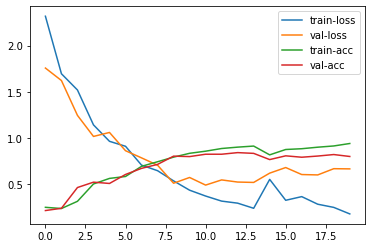

In [ ]:
plt.plot(history_3.history['loss'], label='train-loss')
plt.plot(history_3.history['val_loss'], label='val-loss')
plt.plot(history_3.history['accuracy'], label='train-acc')
plt.plot(history_3.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg3 = vgg_3.evaluate(test_ds)[1]

27/27 [==============================] - 5s 167ms/step - loss: 0.6680 - accuracy: 0.8021


## TransterLearning Part 4 (Change Fully Connected Layers) 

In [ ]:
# lest's first look at the VGG16 architecture without fully Connected 
vgg_test = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
vgg_test.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
def VGG16_4(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

  # for layer in vgg_model.layers[:]:
  #     layer.trainable = False
  # this part is just like:
  vgg_model.trainable = False

  output = vgg_model.get_layer('block5_pool').output # this part is just like vgg_model.layers[-1].output)
  output = layers.Flatten(name='flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_4 = VGG16_4(summary=True)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_4 = vgg_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 25s 223ms/step - loss: 1.6552 - accuracy: 0.6296 - val_loss: 0.6868 - val_accuracy: 0.7558
Epoch 2/20
108/108 [==============================] - 24s 224ms/step - loss: 0.4501 - accuracy: 0.8436 - val_loss: 0.5844 - val_accuracy: 0.7928
Epoch 3/20
108/108 [==============================] - 23s 214ms/step - loss: 0.2894 - accuracy: 0.8983 - val_loss: 0.6134 - val_accuracy: 0.8009
Epoch 4/20
108/108 [==============================] - 24s 218ms/step - loss: 0.1579 - accuracy: 0.9427 - val_loss: 0.7113 - val_accuracy: 0.7928
Epoch 5/20
108/108 [==============================] - 24s 219ms/step - loss: 0.1254 - accuracy: 0.9577 - val_loss: 0.7106 - val_accuracy: 0.8079
Epoch 6/20
108/108 [==============================] - 23s 216ms/step - loss: 0.0727 - accuracy: 0.9722 - val_loss: 0.8688 - val_accuracy: 0.7998
Epoch 7/20
108/108 [==============================] - 24s 218ms/step - loss: 0.1139 - accuracy: 0.9586 - val_loss: 1.2267 - val_ac

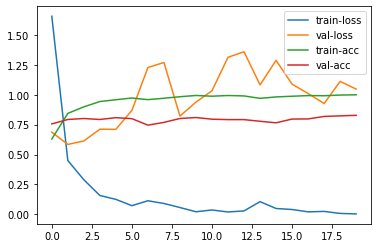

In [ ]:
plt.plot(history_4.history['loss'], label='train-loss')
plt.plot(history_4.history['val_loss'], label='val-loss')
plt.plot(history_4.history['accuracy'], label='train-acc')
plt.plot(history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg4 = vgg_4.evaluate(test_ds)[1]

27/27 [==============================] - 5s 172ms/step - loss: 1.0470 - accuracy: 0.8275


In [ ]:
def anotherVGG16_4(summary=False):

  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
  vgg_model.trainable = False

  inputs = layers.Input(shape=(224,224,3))
  x = vgg_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
another_vgg_4 = anotherVGG16_4(summary=True)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense_7 (Dense)             (None, 7, 7, 1024)        525312    
                                                                 
 dense_8 (Dense)             (None, 7, 7, 1024)        1049600   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_9 (Dropout)         (None, 1024)              0         
                                                           

In [ ]:
start_tra = perf_counter()
another_history_4 = another_vgg_4.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 25s 222ms/step - loss: 1.0094 - accuracy: 0.6221 - val_loss: 0.5864 - val_accuracy: 0.7940
Epoch 2/20
108/108 [==============================] - 24s 218ms/step - loss: 0.5679 - accuracy: 0.7944 - val_loss: 0.5340 - val_accuracy: 0.8056
Epoch 3/20
108/108 [==============================] - 24s 218ms/step - loss: 0.4650 - accuracy: 0.8317 - val_loss: 0.4768 - val_accuracy: 0.8322
Epoch 4/20
108/108 [==============================] - 24s 218ms/step - loss: 0.3737 - accuracy: 0.8619 - val_loss: 0.3910 - val_accuracy: 0.8623
Epoch 5/20
108/108 [==============================] - 24s 219ms/step - loss: 0.3144 - accuracy: 0.8900 - val_loss: 0.3734 - val_accuracy: 0.8762
Epoch 6/20
108/108 [==============================] - 24s 218ms/step - loss: 0.2769 - accuracy: 0.8966 - val_loss: 0.4089 - val_accuracy: 0.8542
Epoch 7/20
108/108 [==============================] - 24s 218ms/step - loss: 0.2325 - accuracy: 0.9169 - val_loss: 0.5479 - val_ac

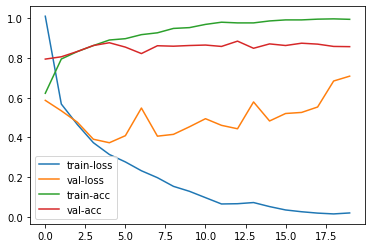

In [ ]:
plt.plot(another_history_4.history['loss'], label='train-loss')
plt.plot(another_history_4.history['val_loss'], label='val-loss')
plt.plot(another_history_4.history['accuracy'], label='train-acc')
plt.plot(another_history_4.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
another_score_vgg4 = another_vgg_4.evaluate(test_ds)[1]

27/27 [==============================] - 5s 171ms/step - loss: 0.7081 - accuracy: 0.8565


## TransferLearinig Part 5 (Open the last trainable layers before fully connected and add some dense/dropout layers)

In [ ]:
def VGG16_5(summary=False):
  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)

  for layer in vgg_model.layers[:]:
      layer.trainable = False
  # this part is just like: vgg_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv1':
      set_trainable=True
    lyr.trainable = set_trainable

  output = vgg_model.get_layer('block5_pool').output # this part is just like vgg_model.layers[-1].output)
  output = layers.Flatten(name='flatten')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc1')(output)
  output = layers.Dense(1024, activation='relu',kernel_initializer='he_normal', name='fc2')(output)
  output = layers.Dropout(0.3)(output)
  output = layers.Dense(5, activation='softmax')(output)

  vgg_model = Model(vgg_model.input, output)
  vgg_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    print(vgg_model.summary())

  return vgg_model

In [ ]:
vgg_5 = VGG16_5(summary=True)

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
start_tra = perf_counter()
history_5 = vgg_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 27s 246ms/step - loss: 1.7696 - accuracy: 0.2465 - val_loss: 1.6044 - val_accuracy: 0.2350
Epoch 2/20
108/108 [==============================] - 26s 243ms/step - loss: 1.5980 - accuracy: 0.2465 - val_loss: 1.6039 - val_accuracy: 0.2350
Epoch 3/20
108/108 [==============================] - 26s 244ms/step - loss: 1.5985 - accuracy: 0.2409 - val_loss: 1.6039 - val_accuracy: 0.2350
Epoch 4/20
108/108 [==============================] - 26s 242ms/step - loss: 1.5989 - accuracy: 0.2441 - val_loss: 1.6032 - val_accuracy: 0.2350
Epoch 5/20
108/108 [==============================] - 26s 242ms/step - loss: 1.5982 - accuracy: 0.2441 - val_loss: 1.6039 - val_accuracy: 0.2350
Epoch 6/20
108/108 [==============================] - 26s 243ms/step - loss: 1.5983 - accuracy: 0.2404 - val_loss: 1.6046 - val_accuracy: 0.2350
Epoch 7/20
108/108 [==============================] - 26s 244ms/step - loss: 1.5986 - accuracy: 0.2438 - val_loss: 1.6033 - val_ac

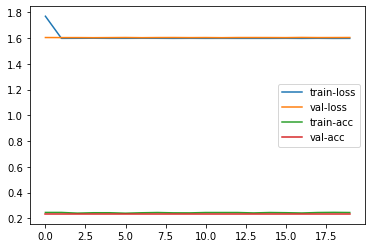

In [ ]:
plt.plot(history_5.history['loss'], label='train-loss')
plt.plot(history_5.history['val_loss'], label='val-loss')
plt.plot(history_5.history['accuracy'], label='train-acc')
plt.plot(history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
score_vgg5 = vgg_5.evaluate(test_ds)[1]

27/27 [==============================] - 5s 164ms/step - loss: 1.6046 - accuracy: 0.2350


In [ ]:
def anotherVGG16_5(summary=False):

  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
  vgg_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv1':
      set_trainable=True
    lyr.trainable = set_trainable

  inputs = layers.Input(shape=(224,224,3))
  x = vgg_model(inputs, training=False)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
another_vgg_5 = anotherVGG16_5(summary=True)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense_11 (Dense)            (None, 7, 7, 1024)        525312    
                                                                 
 dense_12 (Dense)            (None, 7, 7, 1024)        1049600   
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_11 (Dropout)        (None, 1024)              0         
                                                           

In [ ]:
start_tra = perf_counter()
another_history_5 = another_vgg_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 25s 227ms/step - loss: 1.6826 - accuracy: 0.2340 - val_loss: 1.5086 - val_accuracy: 0.4120
Epoch 2/20
108/108 [==============================] - 24s 224ms/step - loss: 1.5262 - accuracy: 0.3397 - val_loss: 1.3957 - val_accuracy: 0.4734
Epoch 3/20
108/108 [==============================] - 24s 217ms/step - loss: 1.4093 - accuracy: 0.4248 - val_loss: 1.2841 - val_accuracy: 0.6007
Epoch 4/20
108/108 [==============================] - 24s 221ms/step - loss: 1.3016 - accuracy: 0.4955 - val_loss: 1.1966 - val_accuracy: 0.6586
Epoch 5/20
108/108 [==============================] - 24s 222ms/step - loss: 1.2225 - accuracy: 0.5491 - val_loss: 1.1216 - val_accuracy: 0.6528
Epoch 6/20
108/108 [==============================] - 24s 218ms/step - loss: 1.1443 - accuracy: 0.5778 - val_loss: 1.0556 - val_accuracy: 0.6806
Epoch 7/20
108/108 [==============================] - 24s 220ms/step - loss: 1.0820 - accuracy: 0.6021 - val_loss: 0.9985 - val_ac

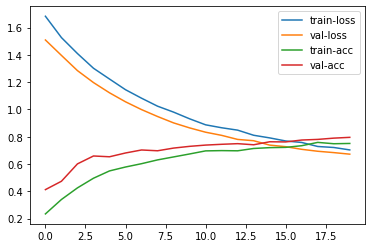

In [ ]:
plt.plot(another_history_5.history['loss'], label='train-loss')
plt.plot(another_history_5.history['val_loss'], label='val-loss')
plt.plot(another_history_5.history['accuracy'], label='train-acc')
plt.plot(another_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
another_score_vgg5 = another_vgg_5.evaluate(test_ds)[1]

27/27 [==============================] - 5s 172ms/step - loss: 0.6719 - accuracy: 0.7951


## Bset One

In [ ]:
def lastVGG16_5(summary=False):

  vgg_model = VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
  vgg_model.trainable = False

  # let the layers after last block be train
  set_trainable = False
  for lyr in vgg_model.layers:
    if lyr.name=='block5_conv1':
      set_trainable=True
    lyr.trainable = set_trainable

  vgg_preprocess = preprocess_input
  inputs = layers.Input(shape=(224,224,3))
  x =  vgg_preprocess(inputs)
  x = vgg_model(inputs, training=False)
  x = layers.GlobalAveragePooling2D()(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dense(1024, activation='relu', kernel_initializer='he_normal')(x)
  x = layers.Dropout(0.3)(x)
  prediction = layers.Dense(5, activation='softmax')(x)

  model = Model(inputs=inputs, outputs=prediction)
  model.compile(optimizer=keras.optimizers.Adam(1e-5),loss='categorical_crossentropy',metrics=['accuracy'])

  if summary:
    print(model.summary())

  return model

In [ ]:
last_vgg_5 = lastVGG16_5(summary=True)

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 dense_14 (Dense)            (None, 7, 7, 1024)        525312    
                                                                 
 dense_15 (Dense)            (None, 7, 7, 1024)        1049600   
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_12 (Dropout)        (None, 1024)              0         
                                                           

In [ ]:
start_tra = perf_counter()
last_history_5 = last_vgg_5.fit(train_ds, epochs=20, batch_size=128, validation_data=test_ds)
end_tra = perf_counter()

time = round((end_tra-start_tra), 2)
print('train phase time: ', time)

Epoch 1/20
108/108 [==============================] - 25s 219ms/step - loss: 1.6643 - accuracy: 0.2268 - val_loss: 1.5157 - val_accuracy: 0.3600
Epoch 2/20
108/108 [==============================] - 24s 218ms/step - loss: 1.5249 - accuracy: 0.3490 - val_loss: 1.3954 - val_accuracy: 0.4907
Epoch 3/20
108/108 [==============================] - 25s 229ms/step - loss: 1.4143 - accuracy: 0.4217 - val_loss: 1.2960 - val_accuracy: 0.5926
Epoch 4/20
108/108 [==============================] - 24s 224ms/step - loss: 1.3104 - accuracy: 0.4920 - val_loss: 1.2018 - val_accuracy: 0.6111
Epoch 5/20
108/108 [==============================] - 24s 225ms/step - loss: 1.2293 - accuracy: 0.5334 - val_loss: 1.1259 - val_accuracy: 0.6366
Epoch 6/20
108/108 [==============================] - 24s 221ms/step - loss: 1.1493 - accuracy: 0.5830 - val_loss: 1.0629 - val_accuracy: 0.6597
Epoch 7/20
108/108 [==============================] - 24s 217ms/step - loss: 1.0876 - accuracy: 0.6015 - val_loss: 1.0012 - val_ac

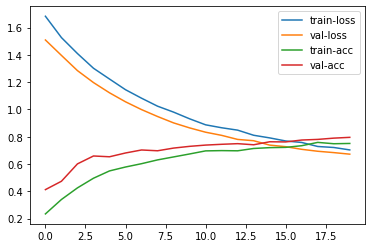

In [ ]:
plt.plot(another_history_5.history['loss'], label='train-loss')
plt.plot(another_history_5.history['val_loss'], label='val-loss')
plt.plot(another_history_5.history['accuracy'], label='train-acc')
plt.plot(another_history_5.history['val_accuracy'], label='val-acc')
plt.legend()

In [ ]:
last_score_vgg5 = last_vgg_5.evaluate(test_ds)[1]

27/27 [==============================] - 5s 172ms/step - loss: 0.6764 - accuracy: 0.7812
